# Pregunta número 3 prueba de selección Cencosud


Realizaremos una análisis simple de series temporales aplicada a las ventas de los diferentes productos de la base de datos solicitada. El enfoque será hacer análisis por cada una de las tiendas por separado. Esto tiende fundamento en que es díficil poder asegurar que un modelo predictivo funcione bien para dos tiendas diferentes, si el comportamiento de sus clientes es completamente diferente, por ejemplo, es diferente un supermercado que está en una localidad pequeña como San Antonio, versus uno instalado en un mall capitalino. Sin embargo, tiendas con comportamiento de clientes *similares* podrían analizarse en conjunto, pero es un análisis que escapa de esta demostración.








In [1]:
from pathlib import Path

import seaborn as sns
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from cencosud import SETTINGS
from cencosud.reflect_db import Ventas
from cencosud.sql import table_to_csv

sns.set(rc={'figure.figsize':(11, 4)})

In [2]:
# Extraeremos la información de ventas historicas de cada uno de los productos de la tienda 1 (simplicidad)
# que se encuentran disponible en la base de datos entregada
table_to_csv(Ventas, Path(SETTINGS.DATA_PATH, "tienda_1_prod_5.csv"), store_id = 1, category_id = 5)
table_to_csv(Ventas, Path(SETTINGS.DATA_PATH, "tienda_1_prod_15.csv"), store_id = 1, category_id = 15)
table_to_csv(Ventas, Path(SETTINGS.DATA_PATH, "tienda_1_prod_27.csv"), store_id = 1, category_id = 27)
table_to_csv(Ventas, Path(SETTINGS.DATA_PATH, "tienda_1_prod_35.csv"), store_id = 1, category_id = 35)

#Mirar la carpeta data que esta en la raiz del proyecto!!!!!!!!!!
#Obviamente esto es una demo, quizas guardar la información filtrada en csv puede ser cambiado por otro enfoque


In [3]:
#Serie temporal de ventas para la tienda 1 y la categoria 5 (Carnes)
tienda_1_prod_5 = pd.read_csv(Path(SETTINGS.DATA_PATH, "tienda_1_prod_5.csv"), parse_dates=["FECHA"],infer_datetime_format=True)
tienda_1_prod_5 = tienda_1_prod_5.set_index("FECHA").sort_index()
tienda_1_prod_5.index = tienda_1_prod_5.index.to_period('D')
tienda_1_prod_5.head(10)

# Me sorprende un poco que el data set entregado, las ventas marquen como hora en su fecha siempre las 12 AM
# imagino que hay missing data. En el análisis asumiremos que el monto de venta corresponde a la cantidad vendida
# en el día completo (no solo a las 12 AM como sale la información horaria). 

,VENTAS
FECHA,
2017-08-01,1142.0
2017-08-02,1079.0
2017-08-03,1096.0
2017-08-04,2430.0
2017-08-05,4261.0
2017-08-06,2545.0
2017-08-07,934.0
2017-08-08,829.0
2017-08-09,873.0


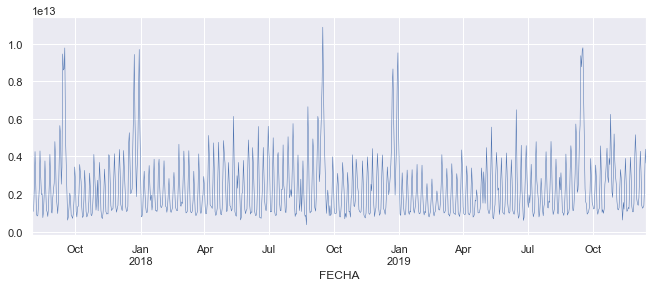

In [9]:
tienda_1_prod_5['VENTAS'] = tienda_1_prod_5['VENTAS']*1000 #Transformación de acuerdo a comentario anterior
tienda_1_prod_5['VENTAS'].plot(linewidth=0.5);

## Observación importante

Notar que la tabla de ventas solo contiene la información de una venta por día (marcando registro horario a las 12 A.M). No tenemos información suficiente para poder sacar conclusiones usando esta data. Supondremos que la información que se dispone expresa la cantidad **total** vendida en ese día y dicho monto se encuentra en miles de pesos. Ahora necesitamos conocer la cantidad de veces que se vendio el producto en un día particular. Para ello

$$ D_t = \frac{S_t}{P_t} $$ 

donde $D_t$ corresponde a la demanda del producto en el tiempo $t$, $S_t$ el total vendido del producto y $P_t$ el precio del producto en dicho día. Dicha información está disponible en la tabla $\texttt{TABLA_PRICING}$. Sin embargo en la base de datos entregada en pricing solo hay una información muy acotada de la tienda número 4 y solo la categoría 27. Por ende solo podremos hacer un anális de predicción sobre la venta. Recordamos que estamos considerando la columna ventas como si fuesen las ventas totales del día.



# Modelo simple

Usaremos un modelo ARIMA "Auto Regressive Integrated Moving Average". Este modelo es clásico en el forecasting de series temporales, que considera que los estados presentes tienen dependencia del pasado (que es denominado como auto regresivo) y que considera posibles errores producto de lo que no se puede controlar (el azar para los más poéticos). Hay una extensión para series de tiempo estacionales, donde se incluye la estacionalidad como parte del estudio. Dicho modelo es llamado SARIMA. En este caso usaremos un ARIMA, no se observa estacionalidad en los datos registrados. Si nos restringimos al mercado de la carne como tal, se puede decir que la demanda se mantiene constante en el año, salvo en las ocasiones puntuales que corresponden a las fiestas (18 de Septiembre, Navidad, etc)



El análisis clásico para modelos ARIMA contempla los siguientes pasos
* Identificar posibles transformaciones a la serie de tiempo original para transformarla en estacionaria
* Determinar el componente ARMA, es decir, el componente auto regresivo y de media movil de nuestra serie. Para ello se identifican los órdenes $p$ y $q$ de los componentes. Recordar que una serie auto regresiva es de la forma $$X_t = \sum_{i = 1}^p \alpha_i X_{t-i} + \epsilon_t$$ donde $\epsilon_t$ corresponde a la variable aleatoria que da la incertitumbre. Y una serie media movil es de la forma $$X_t = \sum_{i = 1}^q \beta_i \epsilon_{t-i} + \mu$$


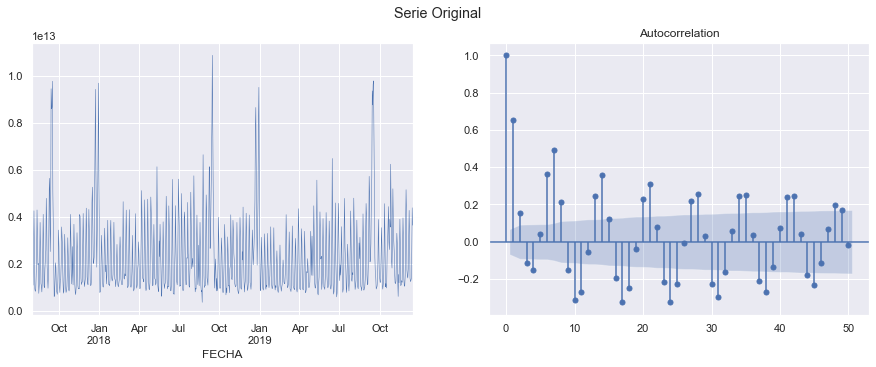

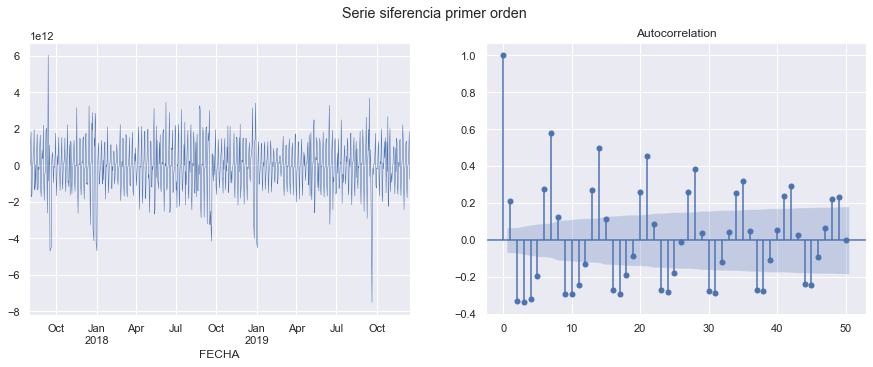

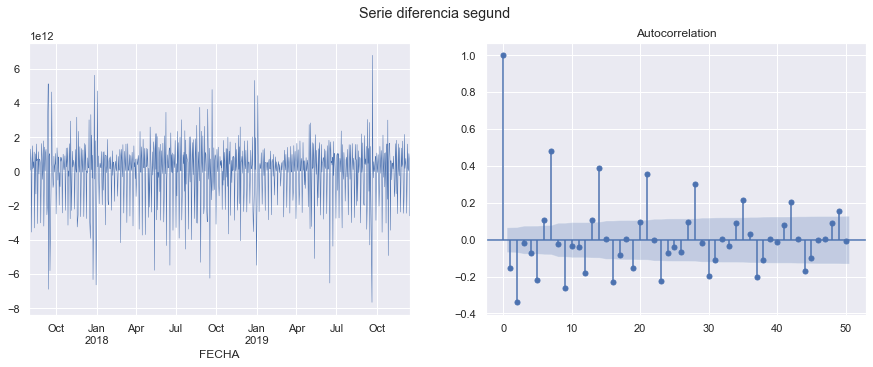

In [11]:
def make_statistic_plots(statistic_method, time_series, title, **kwargs):
    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    time_series.plot(linewidth=0.5, ax = axes[0])
    statistic_method(time_series.dropna(), ax = axes[1], **kwargs)
    fig.suptitle(title)
    plt.show()

make_statistic_plots(plot_acf, tienda_1_prod_5.VENTAS, title = "Serie Original", lags = 50)
make_statistic_plots(plot_acf, tienda_1_prod_5.VENTAS.diff(), title = "Serie siferencia primer orden", lags = 50)
make_statistic_plots(plot_acf, tienda_1_prod_5.VENTAS.diff().diff(), title = "Serie diferencia segund", lags = 50)

# Escogiendo el parámetro de diferencias 
Una explicación intuitiva pero no rigurosa sería señalar que para los procesos estacionarios de media cero, la autocorrelación en el retraso (o lag en ingles) $\tau$ es la correlación entre dos muestras del proceso a una distancia temporal $\tau$. Parece natural que, con ciertos supuestos de regularidad (intuitivo: "suficiente aleatoriedad"), esa correlación debería disminuir (en promedio) con un retraso creciente, y finalmente debería converger a cero para $\tau$ → ∞. Sin embargo hay contra ejemplos que demuestran lo contario, pero son muy escasos y la convención es escoger el parámetro diferenciador como el que "acelera" el decrecimiento a 0 de la ACF. En este caso escogeremos este parámetro con valor 2

# Encontrando el orden AR y MA

c:\users\andre\desktop\cencosud\.venv\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


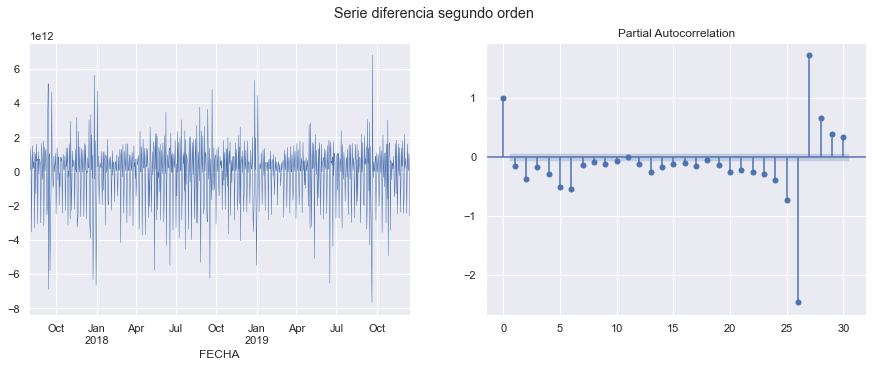

In [20]:
make_statistic_plots(plot_pacf, tienda_1_prod_5.VENTAS.diff().diff(), title = "Serie diferencia segundo orden")

El estudio de la función pacf nos entrega un estimado de cual podría ser el valor del parámetro autoregresivo, esta función considera las correlaciones entre los retrasos sin considerar lo intermedio. Para este caso particular vemos que luego del lag nuúmero 6, la función tiende a estar por debajo de la banda de significancia. Análogamente la acf muestra un nivel de significancia en lag número 2, lo que indca poder escoger el parámetro MA como 2 

In [53]:
from statsmodels.tsa.arima.model import ARIMA
# 6,2,2 ARIMA Model
model = ARIMA(tienda_1_prod_5.VENTAS, order=(6,2,2), enforce_invertibility=False)
model_fit = model.fit()

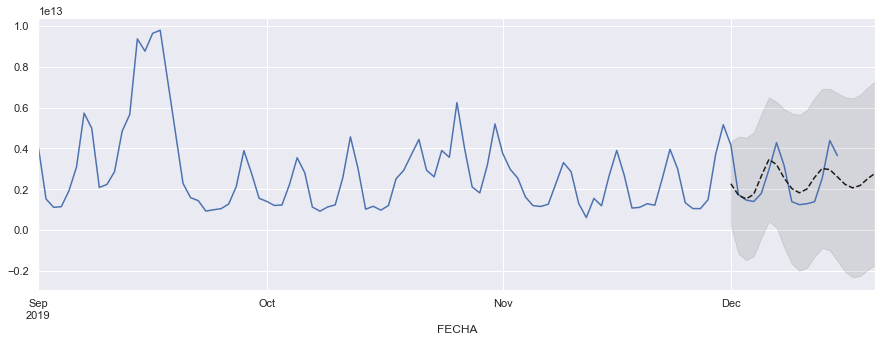

In [52]:
#Gráfico sobre los valores predichos y valores reales de una pequeña muestra

fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
tienda_1_prod_5.VENTAS.loc['2019-09-01':].plot(ax=ax)

fcast = model_fit.get_forecast(20).summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);

# Conclusiones


La problematica sobre predicir demanda es un problema conocido en el mundo del análisis estadístico. En este caso se usó un simple forecasting usando series temporales, en particular un modelo ARIMA. Aún así, un estudio serio debería poder hacer una comparativa entre diversas modelos. Además hay que generar métricas de evaluación como las MAPE o WMAPE. Un estudio de demanda no solo involucra el análisis estadístico, si no también el estudio del mercado en donde se requiere resolución de la problemática. Con respecto a los datos necesarios para poder hacer un modelo de demanda, primer cabe señalar que un estudio de mercado nos podría indicar cuando es necesario considerar tiendas distintas como entes independientes, que es lógico. Pero también hay posibles casos donde un mercado influye directamente sobre el otro (por ejemplo, el mercado del pan esta ligado a los fiambres). Se debiesen incluir más variables, y quizas hacer un análisis multivariado.

En el caso de tener un modelo serio funcionando con la necesidad de presentarlo para una posible implementación, como este modelo no ha sido usado en el mundo real, se podría comparar con modelos actuales implementados que tienen buenos resultados y ver cuales fueron las performance de dichos modelos en la etapa pre productiva.

Ahora para escalar este tipo de problemas se necesita primero una fuerte componente tecnólogica. Ya cuando se trabaja con datos enormes, el análisis con pandas va quedando obsoleto y hay que implementar herramientas Big-Data. De la mano del fuerte análisis matemático/estadístico debe ir una fuerte componente de codificación ordenada y testeada en coordinación con el equipo de trabajo.

